## Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/UNET

/content/drive/MyDrive/UNET


In [ ]:
!pwd

/content/drive/MyDrive/UNET


## Building the model

In [ ]:
from tensorflow import keras
from keras.optimizers import Adam

In [ ]:
# down_block corresponds to the left portion of the UNet structure which downsamples the image
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x) #Convolution layer 1
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c) #Convolution layer 2
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c) #Max pooling with block size = 2x2 and strides = (2,2) to reduce the image size by half by retaining the max value from each 2x2 region in the image
    return c, p

# up_block corresponds to the right portion of the UNet structure which upsamples the image back to its original size on using transposed convolutions
def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x) #Upsamples by repeating rows and columns by 2
    concat = keras.layers.Concatenate()([us, skip]) #Concatenating the upsampled layer(us) with the layer obtained by downsampling in the contraction path of the UNet
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat) #Convolution layer 1
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c) #Convolution layer 2
    return c
# bottleneck corresponds to the bottom-most part of the UNet structure consisting of 2 convolution layers
def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x) #Convolution layer 1
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c) #Convolution layer 2
    return c

In [ ]:
# Defining the UNet model
def UNet():
    f = [64, 128, 256, 512] # Array corresponding to the number of filters
    inputs = keras.layers.Input((image_size, image_size, 1))
    
    # Contraction path with 3 downsampling blocks
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #512 -> 256
    c2, p2 = down_block(p1, f[1]) #256 -> 128 
    c3, p3 = down_block(p2, f[2]) #128 -> 64
    
    bn = bottleneck(p3, f[3])
    
    # Expansion path with 3 upsampling blocks
    u1 = up_block(bn, c3, f[2]) #64 -> 128
    u2 = up_block(u1, c2, f[1]) #128 -> 256
    u3 = up_block(u2, c1, f[0]) #256 -> 512
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u3) # Final output 256x256x1
    model = keras.models.Model(inputs, outputs) # To group layers into an object
    return model

In [ ]:
image_size = 512

## Training the model

In [ ]:
from __future__ import division
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# import models as M
import numpy as np
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
from keras import callbacks
import pickle
   
####################################  Load Data #####################################
folder = './processed_data/'
tr_data    = np.load(folder+'data_train.npy')
tr_mask    = np.load(folder+'Train_maska.npy')
tr_data    = np.expand_dims(tr_data, axis=3)
tr_mask    = np.expand_dims(tr_mask, axis=3)

print('Dataset loaded')

tr_data   = tr_data /255.

print('dataset Normalized')

# Build model
image_size = 512
model = UNet()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

print('Training')
batch_size = 1
nb_epoch   = 10


mcp_save = ModelCheckpoint('weight_lung', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
history = model.fit(tr_data,tr_mask,
              batch_size=batch_size,
              epochs=nb_epoch,
              shuffle=True,
              verbose=1,
              validation_split=0.2, callbacks=[mcp_save, reduce_lr_loss] )
  
print('Trained model saved')
with open('hist_lung', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)




Dataset loaded
dataset Normalized
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                           

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training
Epoch 1/10
571/571 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9590

571/571 [==============================] - 134s 208ms/step - loss: 0.1142 - accuracy: 0.9590 - val_loss: 0.0591 - val_accuracy: 0.9745 - lr: 1.0000e-04
Epoch 2/10
571/571 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9789

571/571 [==============================] - 120s 210ms/step - loss: 0.0546 - accuracy: 0.9789 - val_loss: 0.0329 - val_accuracy: 0.9879 - lr: 1.0000e-04
Epoch 3/10
571/571 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9852

571/571 [==============================] - 118s 207ms/step - loss: 0.0389 - accuracy: 0.9852 - val_loss: 0.0285 - val_accuracy: 0.9884 - lr: 1.0000e-04
Epoch 4/10
571/571 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9884

571/571 [==============================] - 120s 210ms/step - loss: 0.0312 - accuracy: 0.9884 - val_loss: 0.0256 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 5/10
571/571 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9897

571/571 [==============================] - 119s 208ms/step - loss: 0.0279 - accuracy: 0.9897 - val_loss: 0.0147 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 6/10
571/571 [==============================] - 114s 200ms/step - loss: 0.0245 - accuracy: 0.9907 - val_loss: 0.0225 - val_accuracy: 0.9932 - lr: 1.0000e-04
Epoch 7/10
571/571 [==============================] - 115s 202ms/step - loss: 0.0220 - accuracy: 0.9917 - val_loss: 0.0238 - val_accuracy: 0.9922 - lr: 1.0000e-04
Epoch 8/10
571/571 [==============================] - 115s 202ms/step - loss: 0.0215 - accuracy: 0.9919 - val_loss: 0.0197 - val_accuracy: 0.9930 - lr: 1.0000e-04
Epoch 9/10
571/571 [==============================] - 115s 202ms/step - loss: 0.0195 - accuracy: 0.9926 - val_loss: 0.0203 - val_accuracy: 0.9927 - lr: 1.0000e-04
Epoch 10/10
571/571 [==============================] - 113s 199ms/step - loss: 0.0185 - accuracy: 0.9929 - val_loss: 0.0261 - val_accuracy: 0.9910 - lr: 1.0000e-04
Trained model saved


## Evaluating model performance

<ipython-input-8-71a8d5f7724f>:13: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion


Dataset loaded
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                              

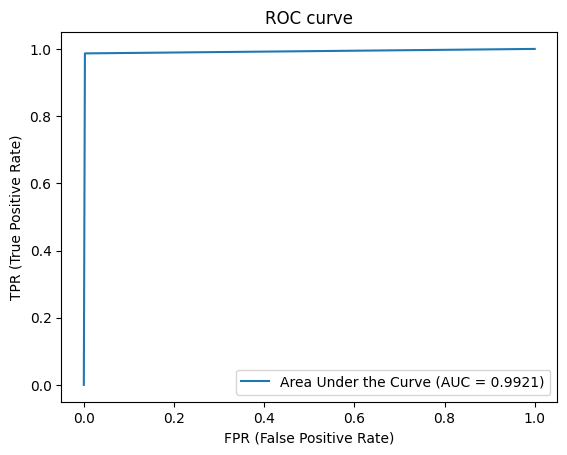

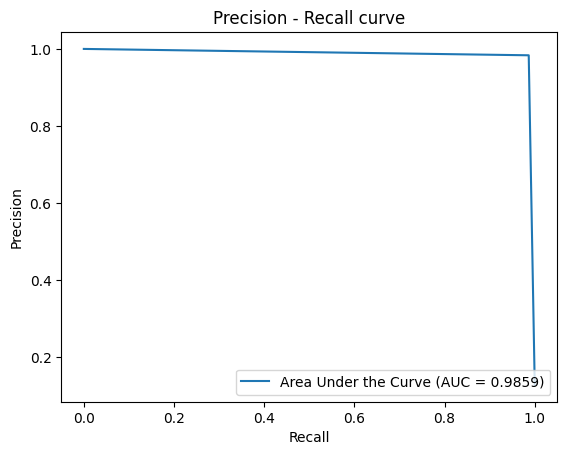

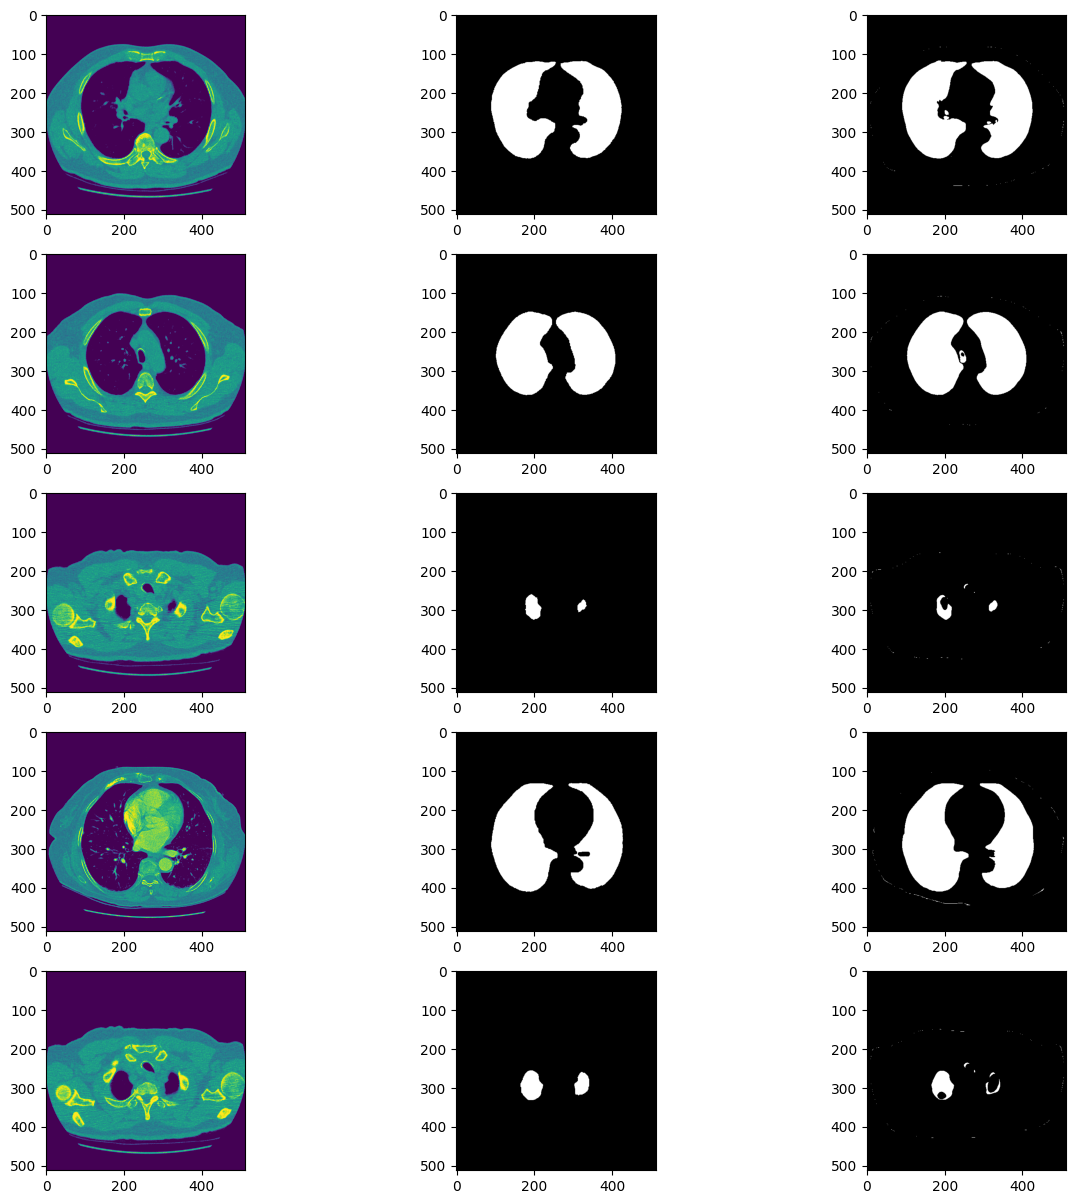

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# import models as M
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from scipy.ndimage.morphology import binary_erosion

####################################  Load Data #####################################
folder    = './processed_data/'
te_data   = np.load(folder+'data_test.npy')
FOV       = np.load(folder+'FOV_te.npy')
te_mask   = np.load(folder+'mask_test.npy')

te_data  = np.expand_dims(te_data, axis=3)

print('Dataset loaded')
#te_data2  = dataset_normalized(te_data)
te_data2 = te_data /255.
model = UNet()
model.summary()
model.load_weights('weight_lung')
predictions = model.predict(te_data2, batch_size=2, verbose=1)

# Post-processing
predictions = np.squeeze(predictions)
predictions = np.where(predictions>0.5, 1, 0)
Estimated_lung = np.where((FOV - predictions)>0.5, 1, 0)

# Performance checking

y_scores = Estimated_lung.reshape(Estimated_lung.shape[0]*Estimated_lung.shape[1]*Estimated_lung.shape[2], 1)
print(y_scores.shape)

y_true = te_mask.reshape(te_mask.shape[0]*te_mask.shape[1]*te_mask.shape[2], 1)

y_scores = np.where(y_scores>0.5, 1, 0)
y_true   = np.where(y_true>0.5, 1, 0)

output_folder = 'output/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
#Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
print ("\nArea under the ROC curve: " +str(AUC_ROC))
roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.savefig(output_folder+"ROC.png")

#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0]
recall = np.fliplr([recall])[0]
AUC_prec_rec = np.trapz(precision,recall)
print ("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(output_folder+"Precision_recall.png")

#Confusion matrix
threshold_confusion = 0.5
print ("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
print (confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print ("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print ("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print ("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print ("Precision: " +str(precision))

#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure): " +str(F1_score))

#Save the results
file_perf = open(output_folder+'performances.txt', 'w')
file_perf.write("Area under the ROC curve: "+str(AUC_ROC)
                + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
                # + "\nJaccard similarity score: " +str(jaccard_index)
                + "\nF1 score (F-measure): " +str(F1_score)
                +"\n\nConfusion matrix:"
                +str(confusion)
                +"\nACCURACY: " +str(accuracy)
                +"\nSENSITIVITY: " +str(sensitivity)
                +"\nSPECIFICITY: " +str(specificity)
                +"\nPRECISION: " +str(precision)
                )
file_perf.close()

# Sample results
fig,ax = plt.subplots(5, 3, figsize=[15,15])
all_ind = [1, 100, 200, 253, 193] # random samples
all_ind = np.array(all_ind)
for idx in range(5):
    ax[idx, 0].imshow(np.uint8(np.squeeze(te_data[all_ind[idx]])))
    ax[idx, 1].imshow(np.squeeze(te_mask[all_ind[idx]]), cmap='gray')  
    ax[idx, 2].imshow(np.squeeze(Estimated_lung[all_ind[idx]]), cmap='gray')  
        
plt.savefig('sample_results.png')